# Code for Section 5: MLPs

This notebook is split into two distinct portions: training and analysis. Training saves all the data required for analysis.
This means that the two parts do not need to be run during the same Jupyter session.

This notebook generates Figures 12 and 13 from (https://arxiv.org/abs/2301.03962v1)

The dataset used in these experiments can be automatically downloaded into the correct directory by running `mnist_download_script.py` in the datasets directory at the top level of this repository.

In [1]:
# PARAMETERS THAT NEED TO BE SET IN BOTH TRAINING/ANALYSIS PARTS
N_TRIALS = 100
DATASET_NAME = "mnist"

# Part A: Training


## Setting up variables

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np
from sklearn.neural_network import MLPClassifier
from decompose.data_utils import load_standard_dataset, load_data
from decompose import BVDExperiment
import logging
import time
import os

if not os.path.exists("images"):
    os.mkdir("images")
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("logs"):
    os.mkdir("logs")
if not os.path.exists("decomposition_objects"):
    os.mkdir("decomposition_objects")


logger = logging.getLogger()
logger_filename = time.strftime("%y_%m_%d_%H_%M_%S")
logging.basicConfig(level=logging.DEBUG,
                    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
                    filename=f"logs/Section4_MLPs_{logger_filename}.log",
                    datefmt="%Y/%m/%d %H:%M:%S")
for logger_name in logging.root.manager.loggerDict:
    logging.getLogger(logger_name).setLevel(logging.CRITICAL)
logging.getLogger("decompose.experiments").setLevel(logging.DEBUG)
logging.debug("New Notebook Started")
stream_handler = logging.StreamHandler




import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../models/")
from bagging_ensembles import GeometricBaggingClassifier



In [3]:

train_data, train_labels, test_data, test_labels = load_data(DATASET_NAME)
PARAMETER_VALUES = range(1, 21, 1)
PARAMETER_NAME = "n_estimators"

results_objects = {}

small_network = GeometricBaggingClassifier(
                                      base_estimator=MLPClassifier(solver='sgd',
                                                       learning_rate_init=0.1,
                                                       max_iter=50,
                                                       n_iter_no_change=50,
                                                       hidden_layer_sizes=(20),
                                                       alpha=0,
                                                       nesterovs_momentum=False,
                                                       verbose=False),
                                      warm_start=True,
                                      smoothing_factor=1e-9)

larger_network = GeometricBaggingClassifier(
                                      base_estimator=MLPClassifier(solver='sgd',
                                                       learning_rate_init=0.1,
                                                       max_iter=50,
                                                       n_iter_no_change=50,
                                                       hidden_layer_sizes=(100),
                                                       alpha=0,
                                                       nesterovs_momentum=False,
                                                       verbose=False),
                                      warm_start=True,
                                      smoothing_factor=1e-9)



models = {"Small Network": small_network,
          "Larger Network": larger_network}



### Training the Models

In [ ]:
for name, model in models.items():
    np.random.seed(0)
    # Create experiment object and define parameter to vary
    experiment = BVDExperiment(model,
                               "cross_entropy",
                               parameter_name=PARAMETER_NAME,
                               parameter_values=PARAMETER_VALUES,
                               trials_progress_bar=True,
                               save_decompositions=True,
                               decompositions_prefix=f"decomposition_objects/{name}_2")
    # Run experiment on data
    results = experiment.run_experiment(train_data, train_labels, test_data, test_labels, n_trials=N_TRIALS, n_test_splits=2)
    results_objects[name] = results
    results.save_results(f"data/Fig4_{name}_{DATASET_NAME}_results_{N_TRIALS}_2.pkl")

  1%|          | 1/100 [00:48<1:19:42, 48.31s/it]


  3%|▎         | 3/100 [02:29<1:20:16, 49.65s/it]


 34%|███▍      | 34/100 [28:18<55:44, 50.68s/it]

# Part B: Analysis

## Set up for Analysis


In [4]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss
from tqdm import tqdm
from functools import partial
import numpy as np

from decompose.experiments import load_results
from decompose.plotting_utils import plot_bvd

# Validation split is used for computing the diversity
# Test split is used for calculating the ensembling advantage (individual 0-1 loss  -  ensemble 0-1 loss) 
VAL_IDX = 0
TEST_IDX = 1

matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)


models = ["Small Network", "Larger Network"]

# Load results objects from experiment
results_objects = {}
for name in models:
    results_objects[name] = load_results(f"data/Fig4_{name}_{DATASET_NAME}_results_{N_TRIALS}_2.pkl")

PARAMETER_VALUES = results_objects["Small Network"].parameter_values

small_results = results_objects["Small Network"]
large_results = results_objects["Larger Network"]
  

decomposition_objects = [partial(small_results.get_decomposition_object, idx, TEST_IDX) for idx in range(len(small_results.parameter_values))]
decomposition_objects += [partial(large_results.get_decomposition_object, idx, TEST_IDX) for idx in range(len(large_results.parameter_values))]



diversities = np.concatenate([small_results.diversity[:,VAL_IDX], large_results.diversity[:, VAL_IDX]])
print("objects loaded")

objects loaded


Small Network test set risk: 0.13650119354747567
Larger Network test set risk: 0.08323106170229128


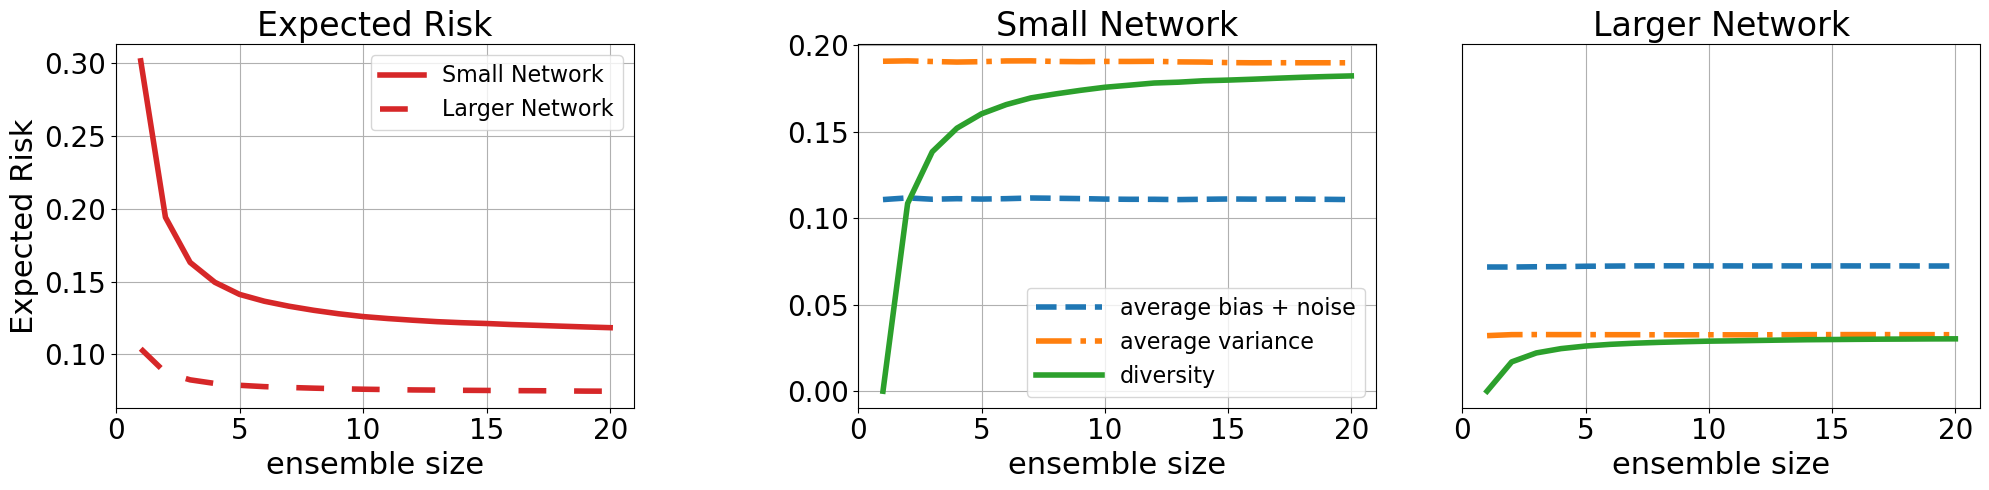

In [5]:
from matplotlib.gridspec import GridSpec

from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize=(20, 5))
gs = GridSpec(1, 4, width_ratios=[5, 0.5, 5, 5])



ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[3], sharey=ax2)
ax3.axes.yaxis.set_visible(False)
axes = [ax1, ax2, ax3]

line_colors = ['tab:red', 'tab:red',  'tab:purple', 'y']
line_styles = ['-', (0, (5, 5)), (0, (5, 1)), '-']


for idx, (name, results) in enumerate(results_objects.items()):

    #risk = results.ensemble_risk[:,0]
    risk = results.ensemble_risk[:, 0]

    axes[0].plot(PARAMETER_VALUES, risk, linewidth=4, c=line_colors[idx], ls=line_styles[idx], label=name )
    #axes[1].set_ylim([0.0 ,.3])
    axes[0].set_xticks(range(0,21,5))
    axes[0].set_title("Expected Risk", fontsize=24)
    axes[0].set_xlabel('ensemble size', fontsize=22)
    axes[0].set_ylabel('Expected Risk', fontsize=22)
    axes[0].tick_params(axis="both", labelsize=20)

axes[0].legend(prop={"size": 16})
axes[0].grid()


mylinewidth=3


for idx, (name, results) in enumerate(results_objects.items()):

    ax = axes[idx+1]
    ax.set_title(name, fontsize=24)

    plot_bvd(results, ensemble_risk=False, axes=ax, show_legend=False, x_label=None)

    ax.set_xlabel("ensemble size", fontsize=22)
    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlim(0, 21)
    
    ax.set_xticks(range(0,21,5))
    ax.tick_params(axis="both", labelsize=20)




    ax.grid(True)

    print(f"{name} test set risk: {results.ensemble_risk[-1, 1]}")

axes[1].legend(prop={"size": 16}, handlelength=3)

fig.subplots_adjust(wspace=0.1, hspace=0)
plt.tight_layout()

plt.savefig(f"images/decomp_comparison_mlp_bagging_{DATASET_NAME}_{N_TRIALS}_combined.pdf", bbox_inches="tight")
plt.show()


## Figure 17: Scatter Plot for MLPs

In [7]:


ambiguities_list = []
ensemble_errors_list = []
average_individual_errors_list = []


for decomp_idx, decomp in enumerate(tqdm(decomposition_objects)):
    decomp = decomp()
    pred = decomp.pred
    labels = decomp.labels

    predicted_class = np.argmax(decomp.pred, axis=3)
    
    average_individual_errors = np.zeros((pred.shape[0]))

    for i in range(pred.shape[1]):
        for j in range(pred.shape[0]):
            average_individual_errors[j] += 1 / pred.shape[1] * zero_one_loss(labels, predicted_class[j, i, :])

    
    # Stuff for ensemble error
    
    ensemble_errors = np.zeros((pred.shape[0]))
    ensemble_preds = decomp._inverse_generator_gradient(
                                        decomp.etas.mean(axis=1, keepdims=False))
    
    predicted_class = np.argmax(ensemble_preds, axis=2)
    for j in range(pred.shape[0]):
        ensemble_errors[j] = zero_one_loss(labels, predicted_class[j, :])
    
    ensemble_errors_list.append(ensemble_errors)
    average_individual_errors_list.append(average_individual_errors)    

100%|██████████| 40/40 [02:53<00:00,  4.33s/it]


In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
from scipy.stats import pearsonr
import matplotlib.ticker as plticker


colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

labels = ["M=5", "M=10", "M=20", "M=5", "M=10", "M=20"]

    
plt.xticks(size=11)
plt.yticks(size=11)

# inset axes....
axins = ax.inset_axes([0.025, 0.26, 0.4, 0.5])

# sub region of the original image

x1, x2, y1, y2 = 0.012, 0.044, .002, .007
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])

FONTSIZE=14

x = np.array(diversities)
y = np.zeros_like(diversities)

for idx in [1, 2, 3, 4]:
    ax.annotate(f"$M={idx + 1}$", (x[idx] + 0.005, y[idx]-0.0005 ), fontsize=FONTSIZE)
    axins.annotate(f"$M={idx + 1}$", (x[idx + 20] + 0.0015, y[idx + 20] - 0.0002 ), fontsize=FONTSIZE)
    
for idx in [19]:
    ax.annotate(f"$M={idx + 1}$", (x[idx] + 0.005, y[idx] - 0.0005 ), fontsize=FONTSIZE)
    axins.annotate(f"$M={idx + 1}$", (x[idx + 20] + 0.0015, y[idx + 20] - 0.00015 ), fontsize=FONTSIZE)



for idx in range(len(diversities)):
    y[idx] = (average_individual_errors_list[idx] - ensemble_errors_list[idx]).mean()

print(x.shape)
print(y.shape)

loc = plticker.MultipleLocator(base=.05)
ax.xaxis.set_major_locator(loc)
ax.set_xlim(right=.24)

small_coeff = (np.corrcoef(x[1:20], y[1:20])**2)[0,1]
print(f"Small R^2 {small_coeff}")
large_coeff = (np.corrcoef(x[21:40], y[21:40])**2)[0,1]
print(f"Large R^2 {large_coeff}")


ax.scatter(x[1:20], y[1:20], c=range(21,40), marker="^", label="Ensemble of Smaller Networks", cmap="Blues", vmin=1)
ax.scatter(x[21:], y[21:], c=range(21,40), label="Ensemble of Larger Networks", cmap="YlOrBr", vmin=1)
axins.scatter(x[21:], y[21:], c=range(21,40), cmap="YlOrBr", vmin=1)

    
for idx in [1, 2, 3, 4]:
    ax.annotate(f"$M={idx + 1}$", (x[idx] + 0.01, y[idx] - 0.0003 ), fontsize=FONTSIZE)
    axins.annotate(f"$M={idx + 1}$", (x[idx + 20] + 0.0005, y[idx + 20] - 0.0003), fontsize=FONTSIZE )
    
for idx in [19]:
    ax.annotate(f"$M={idx + 1}$", (x[idx] + 0.0035, y[idx] - 0.000 ), fontsize=FONTSIZE)
    axins.annotate(f"$M={idx + 1}$", (x[idx + 20] + 0.001, y[idx + 20] - 0.0001 ), fontsize=FONTSIZE)
    

ax.set_xlabel("diversity", fontsize=FONTSIZE)
ax.tick_params(axis="x", labelsize= 14)
ax.tick_params(axis="y", labelsize= 14)
ax.set_ylabel("average individual error \n- ensemble error", fontsize=FONTSIZE)

ax.indicate_inset_zoom(axins, edgecolor="black")
ax.set_box_aspect(1)
plt.legend(prop={"size" : 13 })
plt.savefig(f"images/scatter_diversity_{DATASET_NAME}_{N_TRIALS}_mlps_v3.pdf",  bbox_inches="tight")


(40,)
(40,)
Small R^2 0.9990840533770586
Large R^2 0.9956208048252465
